In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import torchvision


In [2]:
# Utils functions directly taken from the Deep Image Prior implementation
def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size.

    Args:
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img


def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d,
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2),
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np):
    '''Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def generate_noise(input_depth, shape):
  shape = [1, input_depth, shape[0], shape[1]]
  return torch.zeros(shape).uniform_()

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)

    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid

    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"

    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))

    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)

    plt.show()

    return grid


In [3]:
class DownSamplerBlock(nn.Module):
  """
  Downsampling block composed of 2 convolutional layers with associated batch normalization and activation function
  The down sampling effect is done on the first convolutional if stride > 1
  """
  def __init__(self, n_in, n_out, kernel_size, stride=2, pad='zero', bias=True):
    super(DownSamplerBlock, self).__init__()

    if pad == "zero":
      to_pad = int((kernel_size[0] - 1) / 2)

    self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_size, stride=stride, padding=to_pad, bias=bias)
    self.bn1 = nn.BatchNorm2d(n_out)
    self.act1 = nn.LeakyReLU()

    self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=kernel_size, stride=1, padding=to_pad, bias=bias)
    self.bn2 = nn.BatchNorm2d(n_out)
    self.act2 = nn.LeakyReLU()

  def forward(self, x):
    x = self.act1(self.bn1(self.conv1(x)))
    x = self.act2(self.bn2(self.conv2(x)))
    return x

class UpSamplerBlock(nn.Module):
  """
  Upsampling block composed of 2 convolutional layers with associated batch normalization and activation function
  The effective upsampling is done after the 2 convolutional layers
  """
  def __init__(self, n_in, n_out, kernel_size, pad='zero', bias=True, scale_factor=2, mode='nearest'):
    super(UpSamplerBlock, self).__init__()
    if pad == "zero":
      to_pad = int((kernel_size[0] - 1) / 2)

    self.bn0 = nn.BatchNorm2d(n_in)

    self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_in, kernel_size=kernel_size, stride=1, padding=to_pad, bias=bias)
    self.bn1 = nn.BatchNorm2d(n_in)
    self.act1 = nn.LeakyReLU()

    self.conv2 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=(1,1), stride=1, padding=0, bias=bias)
    self.bn2 = nn.BatchNorm2d(n_out)
    self.act2 = nn.LeakyReLU()

    self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode)

  def forward(self, x):
    x = self.bn0(x)
    x = self.act1(self.bn1(self.conv1(x)))
    x = self.act2(self.bn2(self.conv2(x)))
    x = self.upsample(x)
    return x

class EncoderDecoder(nn.Module):
  """
  Encoder Decoder model starting with Downsampling blocks and finishing with Upsampling blocks
  """
  def __init__(self, num_input_channels,
               num_output_channels,
               n_upsampler=[128, 128, 128, 64, 32, 16],
               n_downsampler=[16, 32, 64, 128, 128, 128],
               k_upsampler=[5, 5, 5, 5, 5, 5],
               k_downsampler=[3, 3, 3, 3, 3, 3],
               stride=2,
               pad='zero',
               bias=True,
               scale_factor=2,
               mode_upscale='nearest'):
    super(EncoderDecoder, self).__init__()

    if (len(n_upsampler) != len(k_upsampler)) or (len(n_downsampler) != len(k_downsampler)):
      raise ValueError("Unable to instantiate convolutional layers due to a difference of length between kernel sizes list and input sizes list")

    self.downsample_block1 = DownSamplerBlock(num_input_channels, n_downsampler[0], (k_downsampler[0], k_downsampler[0]), stride=stride, pad=pad, bias=bias)
    self.downsample_block2 = DownSamplerBlock(n_downsampler[0], n_downsampler[1], (k_downsampler[1], k_downsampler[1]), stride=stride, pad=pad, bias=bias)
    self.downsample_block3 = DownSamplerBlock(n_downsampler[1], n_downsampler[2], (k_downsampler[2], k_downsampler[2]), stride=stride, pad=pad, bias=bias)
    self.downsample_block4 = DownSamplerBlock(n_downsampler[2], n_downsampler[3], (k_downsampler[3], k_downsampler[3]), stride=stride, pad=pad, bias=bias)
    self.downsample_block5 = DownSamplerBlock(n_downsampler[3], n_downsampler[4], (k_downsampler[4], k_downsampler[4]), stride=stride, pad=pad, bias=bias)
    # self.downsample_block6 = DownSamplerBlock(n_downsampler[4], n_downsampler[5], (k_downsampler[5], k_downsampler[5]), stride=stride, pad=pad, bias=bias)

    self.upsample_block1 = UpSamplerBlock(n_downsampler[-1], n_upsampler[0], (k_upsampler[0], k_upsampler[0]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)
    self.upsample_block2 = UpSamplerBlock(n_upsampler[0], n_upsampler[1], (k_upsampler[1], k_upsampler[1]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)
    self.upsample_block3 = UpSamplerBlock(n_upsampler[1], n_upsampler[2], (k_upsampler[2], k_upsampler[2]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)
    self.upsample_block4 = UpSamplerBlock(n_upsampler[2], n_upsampler[3], (k_upsampler[3], k_upsampler[3]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)
    self.upsample_block5 = UpSamplerBlock(n_upsampler[3], n_upsampler[4], (k_upsampler[4], k_upsampler[4]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)
    # self.upsample_block6 = UpSamplerBlock(n_upsampler[4], n_upsampler[5], (k_upsampler[5], k_upsampler[5]), pad=pad, bias=bias, scale_factor=scale_factor, mode=mode_upscale)

    self.conv = nn.Conv2d(in_channels=n_upsampler[-1], out_channels=num_output_channels, kernel_size=(1, 1), stride=1, padding=0, bias=bias)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.downsample_block1(x)
    x = self.downsample_block2(x)
    x = self.downsample_block3(x)
    x = self.downsample_block4(x)
    x = self.downsample_block5(x)
    # x = self.downsample_block6(x)

    x = self.upsample_block1(x)
    x = self.upsample_block2(x)
    x = self.upsample_block3(x)
    x = self.upsample_block4(x)
    x = self.upsample_block5(x)
    # x = self.upsample_block6(x)

    x = self.conv(x)

    return self.sigmoid(x)

In [5]:
INPUT = 'noise'
input_depth = 2
LR = 0.01
num_iter = 1001
param_noise = False
show_every = 100
figsize = 5
reg_noise_std = 0.03
dtype = torch.cuda.FloatTensor
OPTIMIZER = 'adam'

In [8]:
img_path  = 'data/library.png'
mask_path = 'data/library_mask.png'
img_pil, img_np = get_image(img_path)
img_mask_pil, img_mask_np = get_image(mask_path)
img_mask_pil = crop_image(img_mask_pil)
img_pil      = crop_image(img_pil)
img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

In [9]:
model = EncoderDecoder(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                      n_upsampler=[128, 128, 128, 128, 128],
                      n_downsampler=[128, 128, 128, 128, 128],
                      k_upsampler=[3, 3, 3, 3, 3],
                      k_downsampler=[3, 3, 3, 3, 3],).type(dtype)

In [10]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in model.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = torch.from_numpy(img_np).type(dtype)
mask_var = torch.from_numpy(img_mask_np).type(dtype)
net_input = generate_noise(input_depth, img_np.shape[1:]).type(dtype)

Number of params: 2157955


In [11]:
model

EncoderDecoder(
  (downsample_block1): DownSamplerBlock(
    (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): LeakyReLU(negative_slope=0.01)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.01)
  )
  (downsample_block2): DownSamplerBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): LeakyReLU(negative_slope=0.01)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.01)
  )
  (downsample_block3): DownSampl

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 448, 704])) that is different to the input size (torch.Size([1, 3, 448, 704])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


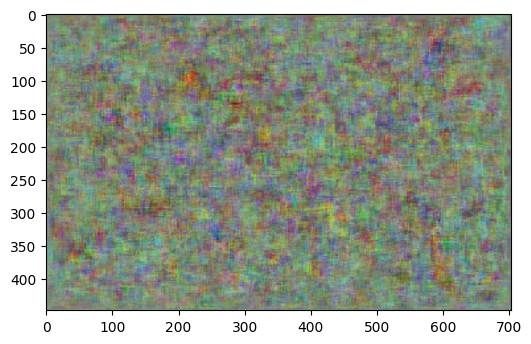

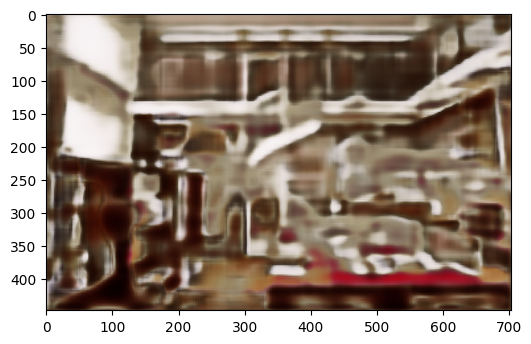

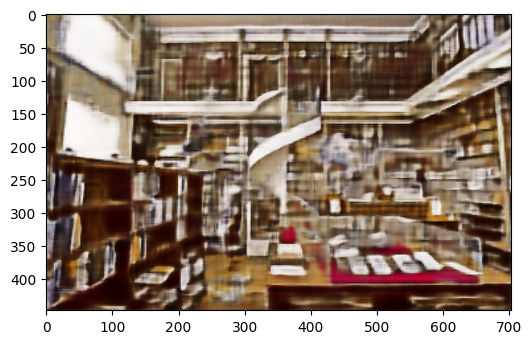

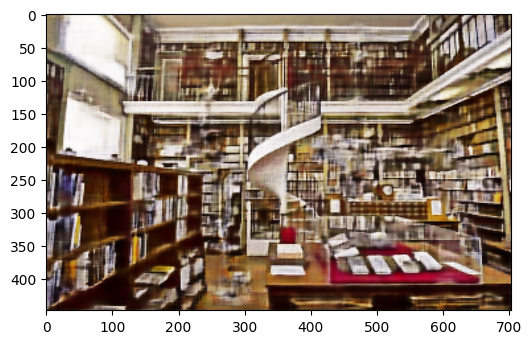

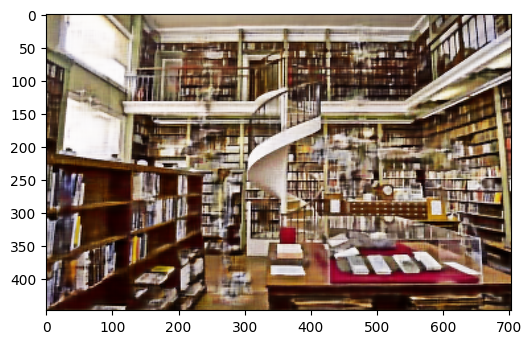

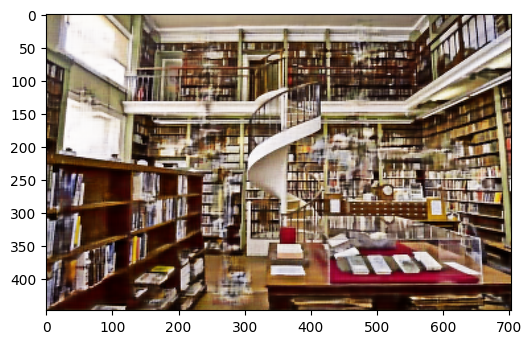

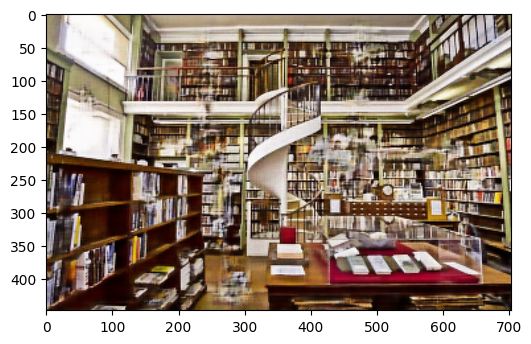

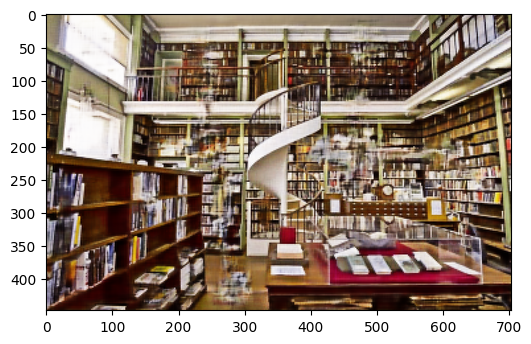

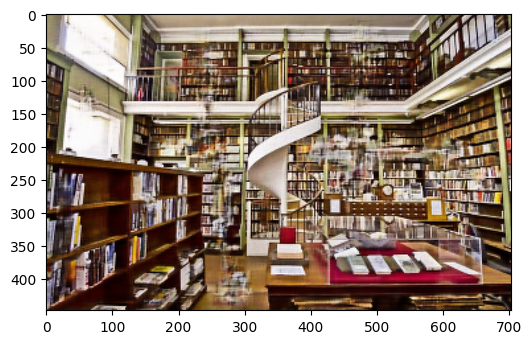

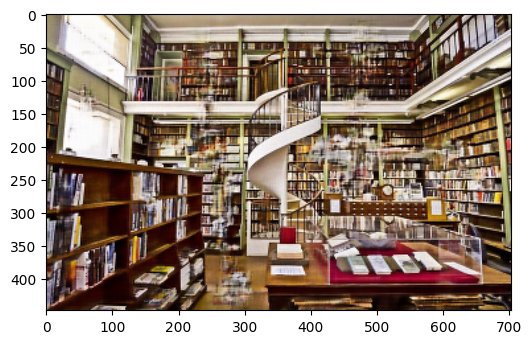

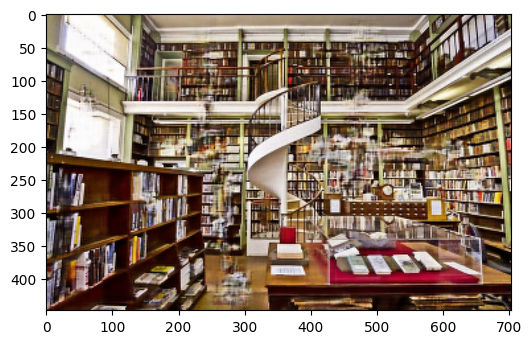

In [12]:
i = 0

def optimize(parameters, closure, LR, num_iter):
  optimizer = torch.optim.Adam(parameters, lr=LR)
  for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

def closure():

    global i


    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = model(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = [x for x in model.parameters()]
optimize(p, closure, LR, num_iter)

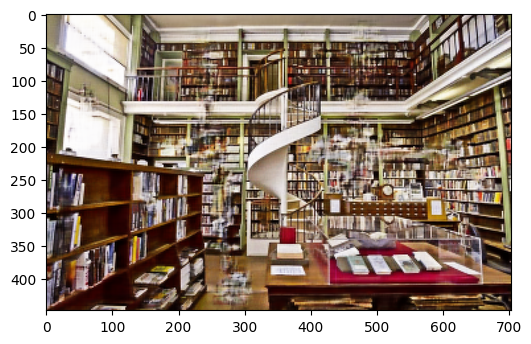

In [13]:
out_np = model(net_input).detach().cpu().numpy()[0]
plot_image_grid([out_np], factor=5);